In [ ]:


!pip install tensorflow_io

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 25.0 MB 1.3 MB/s 


In [ ]:
!pip install pydub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:

import tensorflow_datasets as tfds
(dataset_train_original, dataset_validate_original), info = tfds.load(
    "spoken_digit",
    split = ["train[:80%]", "train[80%:]"],
    as_supervised = True,
    with_info = True
    )
info


tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the beginnings and ends.
    
    5 speakers
    2,500 recordings (50 of each digit per speaker)
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_path='~/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=tf.int64),
        'audio/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=10),
    })

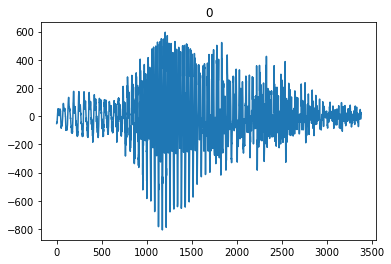

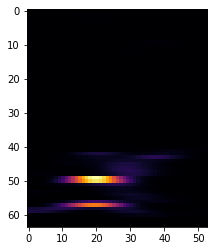

In [ ]:

import tensorflow_io as tfio
import matplotlib.pyplot as plt
import librosa
import numpy as np
from IPython.display import display, Audio
for audio, label in dataset_train_original.shuffle(2500).take(1):
    audio = audio.numpy()
    plt.plot(audio)
    plt.title(f"{label}")
    plt.show()
    plt.close()

    display(Audio(audio, rate=8000))

    mel = librosa.feature.melspectrogram(
        y = audio.astype("float32"), n_mels=64, hop_length=64, sr=8000, fmax=2000
    )

    plt.imshow(mel[::-1,:], cmap="inferno")



(64, 64, 1)


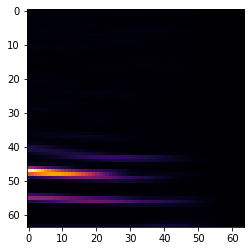

In [ ]:
import tensorflow as tf
def preprocess(audio, label):
  
  audio = tf.cast(audio, tf.float32) /32768.0

  #ccomput spectogram
  spectrogram = tfio.audio.spectrogram(
      audio, nfft=1024, window=1024, stride=64
  )

  #comput melspectogram
  spectrogram = tfio.audio.melscale(
      spectrogram, rate=8000, mels=64, fmin=0, fmax=2000
  )

  #normlize
  spectrogram /= tf.math.reduce_max(spectrogram)

  #Make it 3D
  spectrogram = tf.expand_dims(spectrogram, axis=-1)

  #resize
  spectrogram = tf.image.resize(spectrogram, (64,64))
  #transpose
  spectrogram = tf.transpose(spectrogram, perm=(1, 0, 2))
  
  #flip
  spectrogram = spectrogram[::-1, ::]
  
  return spectrogram, label

dataset = dataset_train_original.map(lambda audio, label: preprocess(audio, label))

for x, y in dataset.take(1):
  print(x.shape)
  plt.imshow(x.numpy().squeeze(), cmap="inferno")
  plt.show()
  plt.close()


In [ ]:
dataset_train = dataset_train_original.map(lambda audio, label: preprocess(audio, label))
dataset_train = dataset_train.cache()
dataset_train = dataset_train.shuffle(2500)
dataset_train = dataset_train.batch(32)

dataset_validate = dataset_validate_original.map(lambda audio, label: preprocess(audio, label))
dataset_validate = dataset_validate.cache()
dataset_validate = dataset_validate.batch(32)

In [ ]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(8, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(16, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))


model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 62, 62, 8)         80        
                                                                 
 average_pooling2d_6 (Averag  (None, 31, 31, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 16)        1168      
                                                                 
 average_pooling2d_7 (Averag  (None, 14, 14, 16)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 average_pooling2d_8 (Averag  (None, 6, 6, 32)        

In [ ]:
history_dict = {}
epochs = 50 

def render_history(history):
    plt.title("Losses")
    plt.plot(history.history["loss"], label="loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.title("Accuracies")
    plt.plot(history.history["accuracy"], label="accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.legend()
    plt.show()
    plt.close()

def compare_histories():
    for training_names, history in history_dict.items():
        plt.plot(history["val_accuracy"], label=training_names)
    plt.legend()
    plt.show()
    plt.close()

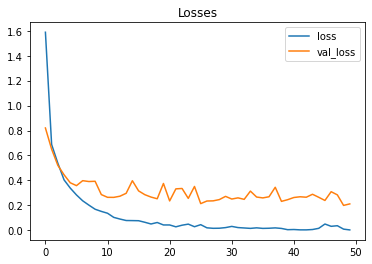

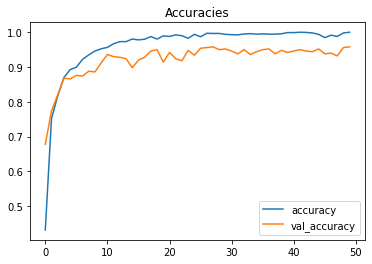

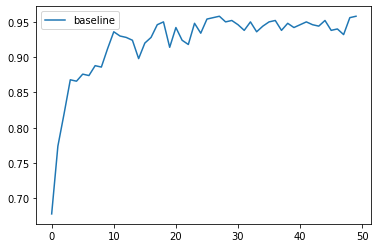

In [ ]:
history_dict["baseline"] = history.history
render_history(history)
compare_histories()

In [ ]:
tf.keras.backend.clear_session()

base_net = tf.keras.applications.vgg19(
    include_top = False,
    weights="imagenet",
    input_shape=(64, 64, 1)
)
# base_net.summary()
base_net.trainable = False

model = models.Sequential()
model.add(base_net)
model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(1, activation="sigmoid"))
model.summary()

In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(8, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(16, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))


model.add(layers.Conv2D(32, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Conv2D(64, (3,3), activation="relu", input_shape=(64,64,1)))
model.add(layers.AveragePooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 62, 62, 8)         80        
                                                                 
 average_pooling2d_9 (Averag  (None, 31, 31, 8)        0         
 ePooling2D)                                                     
                                                                 
 conv2d_10 (Conv2D)          (None, 29, 29, 16)        1168      
                                                                 
 average_pooling2d_10 (Avera  (None, 14, 14, 16)       0         
 gePooling2D)                                                    
                                                                 
 conv2d_11 (Conv2D)          (None, 12, 12, 32)        4640      
                                                                 
 average_pooling2d_11 (Avera  (None, 6, 6, 32)        

Epoch 1/50
63/63 [==============================] - 3s 46ms/step - loss: 1.7772 - accuracy: 0.3385 - val_loss: 1.2979 - val_accuracy: 0.4620
Epoch 2/50
63/63 [==============================] - 5s 81ms/step - loss: 1.0534 - accuracy: 0.5810 - val_loss: 1.0215 - val_accuracy: 0.6140
Epoch 3/50
63/63 [==============================] - 5s 73ms/step - loss: 0.7985 - accuracy: 0.7230 - val_loss: 0.7023 - val_accuracy: 0.7580
Epoch 4/50
63/63 [==============================] - 3s 43ms/step - loss: 0.6218 - accuracy: 0.7800 - val_loss: 0.6947 - val_accuracy: 0.7280
Epoch 5/50
63/63 [==============================] - 3s 43ms/step - loss: 0.5030 - accuracy: 0.8235 - val_loss: 0.5602 - val_accuracy: 0.8060
Epoch 6/50
63/63 [==============================] - 3s 44ms/step - loss: 0.4326 - accuracy: 0.8525 - val_loss: 0.4747 - val_accuracy: 0.8480
Epoch 7/50
63/63 [==============================] - 3s 44ms/step - loss: 0.3449 - accuracy: 0.8845 - val_loss: 0.4811 - val_accuracy: 0.8420
Epoch 8/50
63

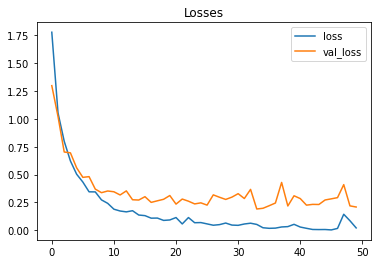

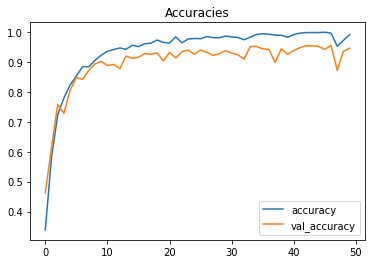

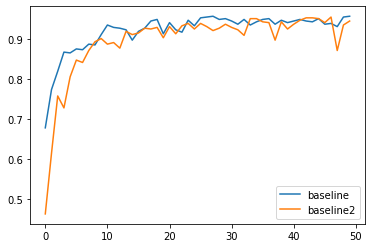

In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

history = model.fit(
    dataset_train,
    validation_data=dataset_validate,
    epochs=50
)

history_dict["baseline2"] = history.history
render_history(history)
compare_histories()